# PyStock Analyzer
---
### Algorithmic Trading program

This program implements algorithmic trading strategies to automate the buying and selling of financial instruments. It uses various technical indicators and market data to make trading decisions. The program is designed to execute trades based on predefined rules and parameters.


### Create a virtual environment, install requirements and import necessary libraries:



In [619]:
import sys
import yfinance as yf

# import finplot as fplt
# from yahoo_fin import stock_info as si

import requests
from bs4 import BeautifulSoup
from prophet import Prophet
from pandas.plotting import autocorrelation_plot
# from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm

import scipy.stats as stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import pandas_datareader as pdr
import pytictoc as tt

#### Define S&P 500 tickers globally:
Parses wiki for the table containing the S&P 500 list, breaks it down to an iterable list: tickers500

In [620]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'id': 'constituents'})

tickers500 = []
for row in table.find_all('tr')[1:]:
    ticker = row.find('td').text.strip()
    tickers500.append(ticker)

print(tickers500)


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DH

# Define Ticker Class:
---
Using the yfinance API we can create our own Ticker class with all of the data and modules of the API available to us along with our own.

## Fundamental Analysis
---

### [Piotroski F-score](https://en.wikipedia.org/wiki/Piotroski_F-score) 
The Piotroski F-score is used to determine a profitability score using various company financial statements as follows:
---
**Profitability** *Score(0 -4)*
- Return on Assets (ROA) (1 point if it is positive in the current year, 0 otherwise)
- Operating Cash Flow (1 point if it is positive in the current year, 0 otherwise)
- Change in Return of Assets (ROA) (1 point if ROA is higher in the current year compared to the previous one, 0 otherwise)
- Accruals (1 point if Operating Cash Flow/Total Assets is higher than ROA in the current year, 0 otherwise)

**Leverage, Liquidity and Source of Funds** *Score(0-3)*
- Change in Leverage (long-term) ratio (1 point if the ratio is lower this year compared to the previous one, 0 otherwise)
- Change in Current ratio (1 point if it is higher in the current year compared to the previous one, 0 otherwise)
- Change in the number of shares (1 point if no new shares were issued during the last year)

**Operating Efficiency** *Score(0-2)*
- Change in Gross Margin (1 point if it is higher in the current year compared to the previous one, 0 otherwise)
- Change in Asset Turnover ratio (1 point if it is higher in the current year compared to the previous one, 0 otherwise)

*Interpretation*
"The highest possible Piotroski score is 9 and the lowest is 0. Higher the score better the value of the company's stock. F-score of 8–9 is considered to be strong. Alternatively, firms achieving the F-score of 0–2 are considered to be weak.

Average value of Piotroski F-score can be different in different branches of economy (e.g. manufacturing, finance, etc.). This should be taken into consideration when comparing companies with different specializations."


### [Altman Z-Score](https://www.investopedia.com/terms/z/zscore.asp#:~:text=Financial%20Review%20Board-,What%20Is%20Z%2DScore%3F,identical%20to%20the%20mean%20score.)
The Altman Z-score, a variation of the traditional z-score in statistics, is based on five financial ratios that can be calculated from data found on a company's annual 10-K report. It uses profitability, leverage, liquidity, solvency, and activity to predict whether a company has a high probability of becoming insolvent as follows:

Altman Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E

Where:

- A = working capital / total assets
- B = retained earnings / total assets
- C = earnings before interest and tax / total assets
- D = market value of equity / total liabilities
- E = sales / total assets

*Interpretation*
"A score below 1.8 means it's likely the company is headed for bankruptcy, while companies with scores above 3 are not likely to go bankrupt. Investors can use Altman Z-scores to determine whether they should buy or sell a stock if they're concerned about the company's underlying financial strength. Investors may consider purchasing a stock if its Altman Z-Score value is closer to 3 and selling or shorting a stock if the value is closer to 1.8.

In more recent years, however, a Z-Score closer to 0 indicates a company may be in financial trouble. In a lecture given in 2019 titled "50 Years of the Altman Score," Professor Altman himself noted that recent data has shown that 0—not 1.8—is the figure at which investors should worry about a company's financial strength"




In [621]:
class Ticker:
    def __init__(self, symbol, start=pd.to_datetime('today') - pd.DateOffset(months=12), end=pd.to_datetime('today')):
        self.symbol = symbol
        self.start = start
        self.end = end
        if '.' in self.symbol:
            self.symbol = self.symbol.replace('.', '-')
        self.df = yf.download(self.symbol, self.start, self.end, progress=False)
        if self.df.empty:
            print("No data found for ", self.symbol)
            sys.exit(1)
        else:
            self.Ticker = yf.Ticker(self.symbol)
            self.actions = self.Ticker.get_actions()
            self.info = self.Ticker.get_info()
            self.balance_sheet = self.Ticker.get_balance_sheet()
            self.income_statement = self.Ticker.get_income_stmt()
            self.cashflow_statement = self.Ticker.get_cashflow()
            self.calendar = self.Ticker.get_calendar()
            self.inst_holders = self.Ticker.get_institutional_holders()
            self.news = self.Ticker.get_news()
            self.recommendations = self.Ticker.get_recommendations()
            try:
                self.analysis = self.Ticker.get_analysis()
            except:
                self.analysis = None
            try:
                self.sustainability = self.Ticker.get_sustainability()
            except:
                self.sustainability = None
            self.profitability = self.get_profitability()
            self.leverage = self.get_leverage()
            self.operating_efficiency = self.get_operating_efficiency()
            self.piotroski = self.get_piotroski()
            self.altman_z_score = self.get_altman_z_score()
    
    def __str__(self):
        return self.symbol

    def __repr__(self):
        return self.symbol
    
    def get_profitability(self) -> dict:
        years = self.balance_sheet.columns

        # Score 1: - Return on Assets
        self.net_income = self.income_statement[years[0]]['NetIncome'] / 1000
        self.total_assets = self.balance_sheet[years[0]]['TotalAssets']
        self.avg_total_assets = (self.total_assets + self.balance_sheet[years[1]]['TotalAssets']) / 2
        self.rota = self.net_income / self.total_assets
        self.roaa = self.net_income / self.avg_total_assets
        roaa_score = 1 if self.roaa > 0 else 0
            
        # Score 2: Operating Cash Flow
        self.operating_cashflow = self.cashflow_statement[years[0]]['CashFlowFromContinuingOperatingActivities']
        operating_cashflow_score = 1 if self.operating_cashflow > 0 else 0

        # Score 3: Change in ROA
        avg_total_assets_py = (self.balance_sheet[years[1]]['TotalAssets'] + self.balance_sheet[years[2]]['TotalAssets']) / 2
        net_income_py = self.income_statement[years[1]]['NetIncome'] / 1000
        self.roa = self.net_income / self.avg_total_assets
        self.roa_py = net_income_py / avg_total_assets_py
        roa_score = 1 if self.roa > 0 else 0

        # Score 4: Accruals
        self.accruals = self.operating_cashflow / self.total_assets - self.roa
        ac_score = 1 if self.accruals > 0 else 0

        self.profitability_score = roaa_score + operating_cashflow_score + roa_score + ac_score

        profitability = {
            'Net Income': self.net_income,
            'ROAA': self.roaa,
            'ROAA Score': roaa_score,
            'Operating Cash Flow': self.operating_cashflow,
            'Operating Cash Flow Score': operating_cashflow_score,
            'ROA': self.roa,
            'ROA PY': self.roa_py,
            'ROA Score': roa_score,
            'Accruals': self.accruals,
            'Accruals Score': ac_score,
            'Profitability Score': self.profitability_score
        }

        return profitability

    def get_leverage(self) -> dict:
        years = self.balance_sheet.columns

        # Score 5: Change in Leverage
        try:
            self.long_term_debt = self.balance_sheet[years[0]]['LongTermDebt']
            self.total_debt = self.balance_sheet[years[0]]['TotalDebt']
            self.long_term_debt_ratio = self.long_term_debt / self.total_debt
            long_term_debt_ratio_py = self.balance_sheet[years[1]]['LongTermDebt'] / self.balance_sheet[years[1]]['TotalDebt']
            long_term_debt_score = 1 if self.long_term_debt_ratio < long_term_debt_ratio_py else 0
        except:
            long_term_debt_score = 0

        # Score 6: Change in Current Ratio
        self.current_assets = self.balance_sheet[years[0]]['CurrentAssets']
        self.current_liabilities = self.balance_sheet[years[0]]['CurrentLiabilities']
        self.current_ratio = self.current_assets / self.current_liabilities
        current_ratio_py = self.balance_sheet[years[1]]['CurrentAssets'] / self.balance_sheet[years[1]]['CurrentLiabilities']
        current_ratio_score = 1 if self.current_ratio > current_ratio_py else 0

        # Score 7: Change in number of shares
        try:
            self.shares_outstanding = self.balance_sheet[years[0]]['CommonStock']
            shares_outstanding_py = self.balance_sheet[years[1]]['CommonStock']
            shares_outstanding_score = 1 if self.shares_outstanding < shares_outstanding_py else 0
        except:
            shares_outstanding_score = 0

        self.leverage_score = long_term_debt_score + current_ratio_score + shares_outstanding_score

        leverage = {
            'Long Term Debt Ratio': self.long_term_debt_ratio,
            'Long Term Debt Score': long_term_debt_score,
            'Current Ratio': self.current_ratio,
            'Current Ratio Score': current_ratio_score,
            'Shares Outstanding': self.shares_outstanding,
            'Shares Outstanding Score': shares_outstanding_score,
            'Leverage Score': self.leverage_score
        }

        return leverage

    def get_operating_efficiency(self) -> dict:
        years = self.balance_sheet.columns

        # Score 8: Change in Gross Margin
        self.gross_profit = self.income_statement[years[0]]['GrossProfit']
        self.revenue = self.income_statement[years[0]]['TotalRevenue']
        self.gross_margin = self.gross_profit / self.revenue
        gross_margin_py = self.income_statement[years[1]]['GrossProfit'] / self.income_statement[years[1]]['TotalRevenue']
        gross_margin_score = 1 if self.gross_margin > gross_margin_py else 0

        # Score 9: Change in Asset Turnover
        self.asset_turnover = self.revenue / self.avg_total_assets
        asset_turnover_py = self.income_statement[years[1]]['TotalRevenue'] / (self.balance_sheet[years[1]]['TotalAssets'] + self.balance_sheet[years[2]]['TotalAssets']) / 2
        asset_turnover_score = 1 if self.asset_turnover > asset_turnover_py else 0

        # Score 10: Change in Inventory Turnover
        try:
            self.inventory = self.balance_sheet[years[0]]['Inventory']
            self.cogs = self.income_statement[years[0]]['CostOfRevenue']
            self.inventory_turnover = self.cogs / self.inventory
            inventory_turnover_py = self.income_statement[years[1]]['CostOfRevenue'] / self.balance_sheet[years[1]]['Inventory']
            self.inventory_turnover_score = 1 if self.inventory_turnover > inventory_turnover_py else 0
        except:
            self.inventory_turnover_score = 0

        self.operating_efficiency_score = gross_margin_score + asset_turnover_score 

        operating_efficiency = {
            'Gross Margin': self.gross_margin,
            'Gross Margin Score': gross_margin_score,
            'Asset Turnover': self.asset_turnover,
            'Asset Turnover Score': asset_turnover_score,
            'Inventory Turnover': self.inventory_turnover,
            'Inventory Turnover Score': self.inventory_turnover_score,
            'Operating Efficiency Score': self.operating_efficiency_score
        }
        return operating_efficiency

    def get_piotroski(self) -> dict:
        self.f_score = self.profitability['Profitability Score'] + self.leverage['Leverage Score'] + self.operating_efficiency['Operating Efficiency Score']
        
        piotroski = {
            'Profitability Score': self.profitability['Profitability Score'],
            'Leverage Score': self.leverage['Leverage Score'],
            'Operating Efficiency Score': self.operating_efficiency['Operating Efficiency Score'],
            'F-Score': self.f_score
        }
        return piotroski

    def get_altman_z_score(self):
        altman_z_score = 1.2 * self.profitability['ROAA'] + 1.4 * self.leverage['Current Ratio'] + 3.3 * self.operating_efficiency['Asset Turnover'] + 0.6 * self.leverage['Long Term Debt Ratio'] + 1.0 * self.profitability['Accruals']
        return altman_z_score

## [Z-Score](https://www.investopedia.com/terms/z/zscore.asp#:~:text=Financial%20Review%20Board-,What%20Is%20Z%2DScore%3F,identical%20to%20the%20mean%20score.)
Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.

The statistical formula for a value's z-score is calculated using the following formula:

z = ( x - μ ) / σ

Where:

- z = Z-score
- x = the value being evaluated
- μ = the mean
- σ = the standard deviation

*Interpretation*
A Z-Score is a statistical measurement of a score's relationship to the mean in a group of scores.
A Z-score can reveal to a trader if a value is typical for a specified data set or if it is atypical.
In general, a Z-score of -3.0 to 3.0 suggests that a stock is trading within three standard deviations of its mean.
Traders have developed many methods that use z-score to identify correlations between trades, trading positions, and evaluate trading strategies.

In [622]:


def add_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data

def get_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data['Z Score ' + frame]
    



# [Technical Analysis](https://www.investopedia.com/terms/t/technicalanalysis.asp)
Technical analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. Unlike fundamental analysis, which attempts to evaluate a security's value based on business results such as sales and earnings, technical analysis focuses on the study of price and volume.


## [Technical Indicators](https://www.investopedia.com/top-7-technical-analysis-tools-4773275)
"Technical indicators are used by traders to gain insight into the supply and demand of securities and market psychology. Together, these indicators form the basis of technical analysis. Metrics, such as trading volume, provide clues as to whether a price move will continue. In this way, indicators can be used to generate buy and sell signals."

Seven of the best indicators for day trading are:

On-balance volume (OBV)
Accumulation/distribution (A/D) line
Average directional index
Aroon oscillator
Moving average convergence divergence (MACD)
Relative strength index (RSI)
Stochastic oscillator

*Interpretation*
"Technical analysis is the reading of market sentiment via the use of graph patterns and signals. Various empirical studies have pointed to its effectiveness, but the range of success is varied and its accuracy remains undecided. It is best to use a suite of technical tools and indicators in tandem with other techniques like fundamental analysis to improve reliability."

In [623]:
class TechnicalAnalysis:
    def __init__(self, ticker: Ticker):
        self.Ticker = ticker
        self.df = self.Ticker.df

        for method in dir(self):
            if method.startswith('add_'):
                df_name = method.split('add_')[1] + '_df'
                self.df_name = self.df.copy(deep=True)
                self.df_name = getattr(self, method)()
    
    def add_z_score(self, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
        self.df['Z Score ' + frame] = (self.df[frame] - self.df[frame].rolling(window= window1).mean()) / self.df[frame].rolling(window= window1).std()
        return self.df


    def add_short_term_moving_averages(self) -> pd.DataFrame:
        self.df['SMA_10'] = ta.trend.sma_indicator(self.df['Adj Close'], window=10)
        self.df['SMA_20'] = ta.trend.sma_indicator(self.df['Adj Close'], window=20)
        self.df['SMA_30'] = ta.trend.sma_indicator(self.df['Adj Close'], window=30)
        return self.df


    def add_long_term_moving_averages(self) -> pd.DataFrame:
        self.df['SMA_50'] = ta.trend.sma_indicator(self.df['Adj Close'], window=50)
        self.df['SMA_100'] = ta.trend.sma_indicator(self.df['Adj Close'], window=100)
        self.df['SMA_200'] = ta.trend.sma_indicator(self.df['Adj Close'], window=200)
        return self.df

    def add_exponential_moving_averages(self) -> pd.DataFrame:
        self.df['EMA_50'] = ta.trend.ema_indicator(self.df['Adj Close'], window=50)
        self.df['EMA_200'] = ta.trend.ema_indicator(self.df['Adj Close'], window=200)
        return self.df

    def add_macd(self) -> pd.DataFrame:
        self.df['MACD'] = ta.trend.macd_diff(self.df['Adj Close'])
        self.df['MACD Signal'] = ta.trend.macd_signal(self.df['Adj Close'])
        self.df['MACD Histogram'] = ta.trend.macd_diff(self.df['Adj Close']) - ta.trend.macd_signal(self.df['Adj Close'])
        return self.df

    def add_bollinger_bands(self) -> pd.DataFrame:
        self.df['BollingerBandHigh'] = ta.volatility.bollinger_hband(self.df['Adj Close'])
        self.df['BollingerBandLow'] = ta.volatility.bollinger_lband(self.df['Adj Close'])
        self.df['BollingerMAvg'] = ta.volatility.bollinger_mavg(self.df['Adj Close'])
        self.df['Bollinger%b'] = ta.volatility.bollinger_pband(self.df['Adj Close'])
        self.df['Bollinger Width'] = ta.volatility.bollinger_wband(self.df['Adj Close'])
        return self.df

    def add_keltner_channels(self) -> pd.DataFrame:
        self.df['KeltnerH'] = ta.volatility.keltner_channel_hband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['KeltnerL'] = ta.volatility.keltner_channel_lband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['KeltnerWidth'] = ta.volatility.keltner_channel_wband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        return self.df

    def add_donchian_channels(self) -> pd.DataFrame:
        self.df['DonchianH'] = ta.volatility.donchian_channel_hband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['DonchianL'] = ta.volatility.donchian_channel_lband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['DonchianWidth'] = ta.volatility.donchian_channel_wband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        return self.df

    def add_vortex_indicator(self) -> pd.DataFrame:
        self.df['Vortex+'] = ta.trend.vortex_indicator_pos(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['Vortex-'] = ta.trend.vortex_indicator_neg(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['VortexSignal'] = self.df['Vortex+'] - self.df['Vortex-']
        return self.df

    def add_ichimoku_cloud(self) -> pd.DataFrame:
        self.df['IchimokuA'] = ta.trend.ichimoku_a(self.df['High'], self.df['Low'])
        self.df['IchimokuB'] = ta.trend.ichimoku_b(self.df['High'], self.df['Low'])
        self.df['IchimokuBaseLine'] = ta.trend.ichimoku_base_line(self.df['High'], self.df['Low'])
        self.df['IchimokuConvLine'] = ta.trend.ichimoku_conversion_line(self.df['High'], self.df['Low'])
        return self.df

    def add_aroon(self) -> pd.DataFrame:
        self.df['AroonUp'] = ta.trend.aroon_up(self.df['High'], self.df['Low'])
        self.df['AroonDown'] = ta.trend.aroon_down(self.df['High'], self.df['Low'])
        self.df['AroonInd'] = self.df['AroonUp'] - self.df['AroonDown']
        return self.df

    def add_kst(self) -> pd.DataFrame:
        self.df['KST'] = ta.trend.kst(self.df['Adj Close'])
        self.df['KSTsig'] = ta.trend.kst_sig(self.df['Adj Close'])
        self.df['KSTdiff'] = self.df['KST'] - self.df['KSTsig']
        return self.df

    # def add_candlestick_patterns(self) -> pd.DataFrame:
    #     self.df['Doji'] = ta.CDLDOJI(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Engulfing'] = ta.CDLENGULFING(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Harami'] = ta.CDLHARAMI(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Hammer'] = ta.CDLHAMMER(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Inverted Hammer'] = ta.CDLINVERTEDHAMMER(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Morning Star'] = ta.CDLMORNINGSTAR(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Shooting Star'] = ta.CDLSHOOTINGSTAR(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Three Black Crows'] = ta.CDL3BLACKCROWS(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     self.df['Three White Soldiers'] = ta.CDL3WHITESOLDIERS(self.df['Open'], self.df['High'], self.df['Low'], self.df['Close'])
    #     return self.df

    # def add_fibonacci_retracement(self) -> pd.DataFrame:
    #     self.df['Fibonacci 23.6'] = ta.trend.fib_retracement(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.236)
    #     self.df['Fibonacci 38.2'] = ta.trend.fib_retracement(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.382)
    #     self.df['Fibonacci 50'] = ta.trend.fib_retracement(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.5)
    #     self.df['Fibonacci 61.8'] = ta.trend.fib_retracement(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.618)
    #     return self.df

    # def add_fibonacci_fans(self) -> pd.DataFrame:
    #     self.df['Fibonacci 38.2 Fan'] = ta.trend.fib_fan(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.382)
    #     self.df['Fibonacci 50 Fan'] = ta.trend.fib_fan(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.5)
    #     self.df['Fibonacci 61.8 Fan'] = ta.trend.fib_fan(self.df['Low'], self.df['High'], self.df['Adj Close'], 0.618)
    #     return self.df

    # def add_pivot_points(self) -> pd.DataFrame:
    #     self.df['Pivot Points'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])
    #     self.df['R1'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['R1']
    #     self.df['R2'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['R2']
    #     self.df['R3'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['R3']
    #     self.df['S1'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['S1']
    #     self.df['S2'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['S2']
    #     self.df['S3'] = ta.trend.pivotpoints(self.df['High'], self.df['Low'], self.df['Adj Close'])['S3']
    #     return self.df

    def add_momentum_indicators(self) -> pd.DataFrame:
        self.df['RSI'] = ta.momentum.rsi(self.df['Adj Close'])
        self.df['TSI'] = ta.momentum.tsi(self.df['Adj Close'])
        self.df['Awesome Oscillator'] = ta.momentum.awesome_oscillator(self.df['High'], self.df['Low'])
        self.df['Ultimate Oscillator'] = ta.momentum.ultimate_oscillator(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['Stoch'] = ta.momentum.stoch(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['Stoch Signal'] = ta.momentum.stoch_signal(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['Williams %R'] = ta.momentum.williams_r(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['KAMA'] = ta.momentum.kama(self.df['Adj Close'])
        self.df['PPO'] = ta.momentum.ppo(self.df['Adj Close'])
        self.df['ROC'] = ta.momentum.roc(self.df['Adj Close'])
        return self.df

    def add_trend_indicators(self) -> pd.DataFrame:
        self.df['ADX'] = ta.trend.adx(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['CCI'] = ta.trend.cci(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['DPO'] = ta.trend.dpo(self.df['Adj Close'])
        self.df['EMA'] = ta.trend.ema_indicator(self.df['Adj Close'])
        self.df['Ichimoku'] = ta.trend.ichimoku_a(self.df['High'], self.df['Low'])
        self.df['KST'] = ta.trend.kst(self.df['Adj Close'])
        self.df['MACD'] = ta.trend.macd_diff(self.df['Adj Close'])
        self.df['Mass Index'] = ta.trend.mass_index(self.df['High'], self.df['Low'])
        self.df['Parabolic SAR'] = ta.trend.psar_up(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['TRIX'] = ta.trend.trix(self.df['Adj Close'])
        self.df['Stooq'] = ta.trend.stc(self.df['Adj Close'])
        return self.df

    def add_volume_indicators(self) -> pd.DataFrame:
        self.df['VWAP'] = ta.volume.volume_weighted_average_price(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df['ForceIndex'] = ta.volume.force_index(self.df['Adj Close'], self.df['Volume'])
        self.df['Accumulation/Distribution'] = ta.volume.acc_dist_index(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df['Chaikin'] = ta.volume.chaikin_money_flow(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df['EOM'] = ta.volume.ease_of_movement(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df['FI'] = ta.volume.force_index(self.df['Adj Close'], self.df['Volume'])
        self.df['MFI'] = ta.volume.money_flow_index(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df['OBV'] = ta.volume.on_balance_volume(self.df['Adj Close'], self.df['Volume'])
        self.df['VPT'] = ta.volume.volume_price_trend(self.df['Adj Close'], self.df['Volume'])
        return self.df


    def add_volatility_indicators(self) -> pd.DataFrame:
        self.df['ATR'] = ta.volatility.average_true_range(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df['Ulcer Index'] = ta.volatility.ulcer_index(self.df['Adj Close'])
        return self.df

    # def plot_candlestick(self):
    #     fplt.candlestick_ochl(self.df[['Open', 'Close', 'High', 'Low']])
    #     fplt.show()



    def plot_z_score(self):
        plt.figure(figsize=(20, 10))
        self.z_score_df = self.df[['Adj Close', 'Z Score Adj Close']].copy(deep=True)
        self.z_score_df.dropna(inplace=True)
        plt.plot(self.z_score_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.z_score_df['Z Score Adj Close'], label='Z Score', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()

    def plot_short_sma(self):
        plt.figure(figsize=(20, 10))
        self.short_sma_df = self.df[['Adj Close', 'SMA_10', 'SMA_20', 'SMA_30']].copy(deep=True)
        self.short_sma_df.dropna(inplace=True)
        plt.plot(self.short_sma_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.short_sma_df['SMA_10'], label='SMA 10', alpha=0.5)
        plt.plot(self.short_sma_df['SMA_20'], label='SMA 20', alpha=0.5)
        plt.plot(self.short_sma_df['SMA_30'], label='SMA 30', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()

    def plot_long_sma(self):
        plt.figure(figsize=(20, 10))
        self.long_sma_df = self.df[['Adj Close', 'SMA_50', 'SMA_100', 'SMA_200']].copy(deep=True)
        self.long_sma_df.dropna(inplace=True)
        plt.plot(self.long_sma_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.long_sma_df['SMA_50'], label='SMA 50', alpha=0.5)
        plt.plot(self.long_sma_df['SMA_100'], label='SMA 100', alpha=0.5)
        plt.plot(self.long_sma_df['SMA_200'], label='SMA 200', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()


    def plot_macd(self):
        plt.figure(figsize=(20, 10))
        self.macd_df = self.df[['MACD', 'MACD Signal', 'MACD Histogram']].copy(deep=True)
        self.macd_df.dropna(inplace=True)
        plt.plot(self.macd_df['MACD'], label='MACD', alpha=1, color='black')
        plt.plot(self.macd_df['MACD Signal'], label='MACD Signal', alpha=0.5)
        plt.bar(self.macd_df.index, self.macd_df['MACD Histogram'], label='MACD Histogram', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()


    def plot_bollinger_bands(self):
        plt.figure(figsize=(20, 10))
        self.bollinger_df = self.df[['Adj Close', 'BollingerBandHigh', 'BollingerBandLow', 'BollingerMAvg']].copy(deep=True)
        self.bollinger_df.dropna(inplace=True)
        plt.plot(self.bollinger_df['Adj Close'], label=self.Ticker.symbol, alpha=1)
        plt.plot(self.bollinger_df['BollingerMAvg'], label='Bollinger Moving Avg(20)', alpha=0.70)
        plt.plot(self.bollinger_df['BollingerBandHigh'], label='Bollinger Band High', alpha=0.55)
        plt.plot(self.bollinger_df['BollingerBandLow'], label='Bollinger Band Low', alpha=0.55)
        plt.legend()
        plt.show()
        plt.close()

    def generate_signal(self):
        conditions = [self.df['RSI'] < 30 & self.df['MACD'] > self.df['MACD Signal'] & self.df['Z Score Adj Close'] < -2,
                        self.df['RSI'] > 70 & self.df['MACD'] < self.df['MACD Signal'] & self.df['Z Score Adj Close'] > 2]
        choices = ['Buy', 'Sell']
        self.df['Signal'] = np.select(conditions, choices, default='Hold')
        self.df.dropna(inplace=True)
        self.df['Signal'] = self.df['Signal'].shift(1)
        return self.df

    def buy_and_hold(self):
        self.df['Buy and Hold'] = self.df['Adj Close'] / self.df['Adj Close'].iloc[0]
        return self.df

    def generate_returns(self):
        self.df['Returns'] = self.df['Adj Close'].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    def generate_sharpe_ratio(self):
        self.sharpe_ratio = (self.df['Returns'].mean() - 0.015) / self.df['Returns'].std()
        return self.sharpe_ratio

    def plot_signals(self):
        plt.figure(figsize=(20, 10))
        self.signals_df = self.df[['Adj Close', 'RSI', 'MACD', 'MACD Signal', 'Z Score Adj Close']].copy(deep=True)
        self.signals_df.dropna(inplace=True)
        plt.plot(self.signals_df['Adj Close'], label=self.Ticker.symbol, alpha=1)
        plt.plot(self.signals_df['RSI'], label='RSI', alpha=0.70)
        plt.plot(self.signals_df['MACD'], label='MACD', alpha=0.55)
        plt.plot(self.signals_df['MACD Signal'], label='MACD Signal', alpha=0.55)
        plt.plot(self.signals_df['Z Score Adj Close'], label='Z Score', alpha=0.55)
        plt.legend()
        plt.show()
        plt.close()

    def autocorrelation_plot(self):
        autocorrelation_plot(self.df['Adj Close'])
        plt.show()
        plt.close()
        
    def generate_correlation_matrix(self):
        self.df.dropna(inplace=True)
        self.correlation_matrix = self.df.corr()
        return self.correlation_matrix

    def generate_prophet_forecast(self, frame= 'Adj Close' ,period=30):
        self.df = self.df.reset_index()
        self.df = self.df.rename(columns={'Date': 'ds', frame: 'y'})
        self.model = Prophet()
        self.model.fit(self.df)
        self.future = self.model.make_future_dataframe(periods=30)
        self.forecast = self.model.predict(self.future)
        self.model.plot(self.forecast)
        self.model.plot_components(self.forecast)
        plt.show()
        plt.close()

    def generate_arima_forecast(self):
        self.df.dropna(inplace=True)
        self.model = ARIMA(self.df['Adj Close'], order=(5, 1, 0))
        self.model_fit = self.model.fit(disp=0)
        self.forecast = self.model_fit.forecast(steps=365)
        plt.plot(self.forecast)
        plt.show()
        plt.close()
        return self.forecast

In [624]:
class Positions:
    def __init__(self):
        self.positions = {}
        self.cash = 1000000
        self.equity = 0
        self.profit = 0
        self.total_value = 0
        self.total_profit = 0
        self.total_equity = 0
        self.trades = {date, ticker, amount, price, type}

    def buy(self, ticker: Ticker, amount: int):
        if self.cash < amount:
            print("Not enough cash to buy ", ticker.symbol)
        else:
            self.cash -= amount
            self.equity += amount
            self.positions[ticker.symbol] = amount
            print("Bought ", amount, " shares of ", ticker.symbol)

    def sell(self, ticker: Ticker, amount: int):
        if ticker.symbol not in self.positions:
            print("No position in ", ticker.symbol)
        elif self.positions[ticker.symbol] < amount:
            print("Not enough shares to sell")
        else:
            self.cash += amount
            self.equity -= amount
            self.positions[ticker.symbol] -= amount
            print("Sold ", amount, " shares of ", ticker.symbol)

    def calculate_profit(self, ticker: Ticker):
        self.profit = (ticker.df['Adj Close'].iloc[-1] - ticker.df['Adj Close'].iloc[0]) * self.positions[ticker.symbol]
        return self.profit

    def calculate_total_value(self):
        self.total_value = self.cash + self.equity
        return self.total_value

    def calculate_total_profit(self):
        self.total_profit = self.total_value - 1000000
        return self.total_profit

/workspaces/AlgorithmicTrading/.venv/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:27 - cmdstanpy - INFO - Chain [1] done processing
/workspaces/AlgorithmicTrading/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/workspaces/AlgorithmicTrading/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a futu

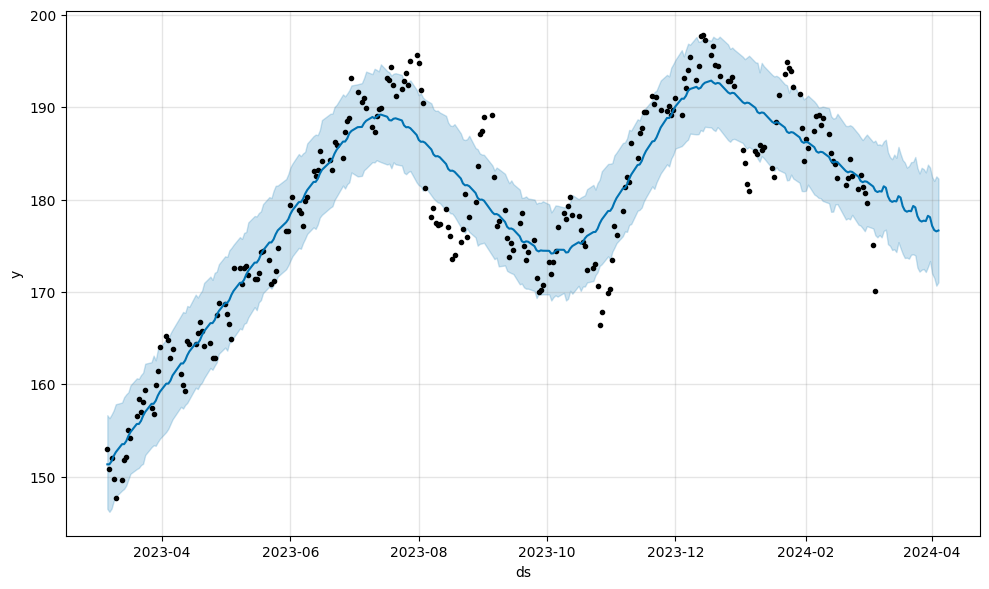

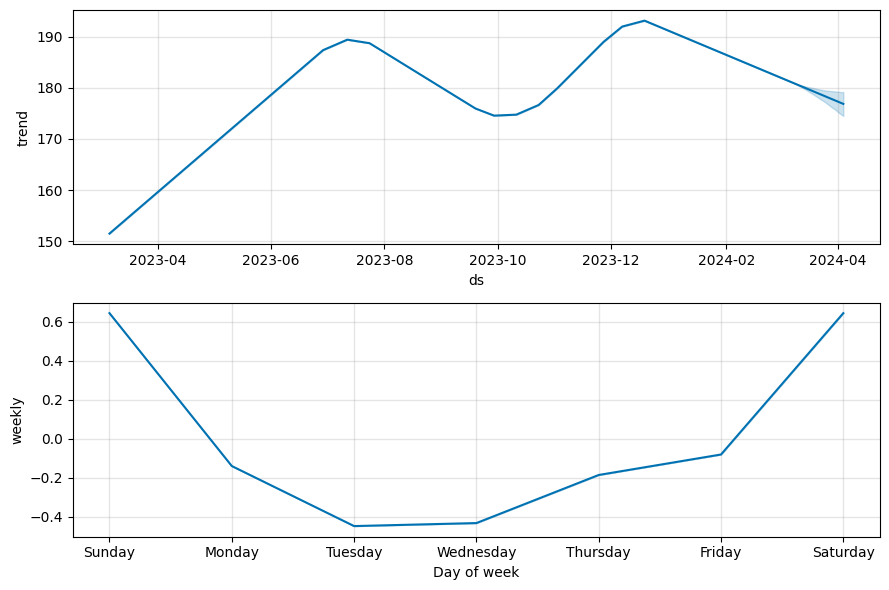

ValueError: cannot reindex on an axis with duplicate labels

In [625]:
aapl = Ticker('AAPL')
aapl_ta = TechnicalAnalysis(aapl)

aapl_ta.generate_prophet_forecast(frame = 'Adj Close')
# aapl_ta.generate_prophet_forecast(frame = 'Open')

# aapl_ta.generate_arima_forecast()

aapl_ta.autocorrelation_plot()

# aapl_ta.generate_correlation_matrix()

# Trading Strategy

    Combining multiple strategies in algorithmic trading is a common approach to enhance robustness and performance. Traders often use a mix of trend-following, mean-reversion, and other strategies to adapt to different market conditions. Here are some common combinations of strategies that we will attempt to utilize:


1) Trend Following with Moving Averages:
    Combining a trend-following strategy using moving averages, such as the Golden Cross (short-term moving average crossing above the long-term moving average), with filters like the Relative Strength Index (RSI) to avoid overbought or oversold conditions.

2) Mean-Reversion with Bollinger Bands:

    Utilizing mean-reversion strategies with Bollinger Bands. Trades are initiated when prices move beyond standard deviations from the moving average, suggesting potential mean-reverting behavior.

3) Momentum and Trend Following:

    Integrating momentum indicators like the Moving Average Convergence Divergence (MACD) with trend-following strategies. This combination aims to capture both short-term momentum and long-term trends.
4) Breakout and Volatility:

    Combining breakout strategies with volatility measures, such as the Average True Range (ATR). This helps identify potential price breakouts and adjusts for different market conditions.

5) Dual Moving Average Crossover with RSI:

    Using a dual moving average crossover strategy along with RSI for confirmation. For example, entering a long position when the short-term moving average crosses above the long-term moving average and the RSI is below a certain threshold.

6) Statistical Arbitrage:

    Employing pairs trading or cointegration strategies to identify and exploit relative price movements between correlated assets. This involves simultaneously buying and selling related instruments to capture price divergences.

7) Machine Learning Hybrid Strategies:

    Integrating machine learning models, such as neural networks or decision trees, to enhance traditional strategies. Machine learning algorithms can adapt to complex patterns and changing market conditions.

8) Event-Driven Strategies:

    Combining event-driven strategies with technical indicators. Event-driven strategies involve reacting to specific events or news, and technical indicators can be used for entry and exit points.

9) Market Microstructure Strategies:

    Utilizing strategies based on market microstructure, such as order book analysis, bid-ask spread dynamics, and order flow analysis. These strategies are often employed in high-frequency trading.

# [FB Prophet](https://facebook.github.io/prophet/)
"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."